# Loader

Here we prepare a list containing all our slices from all the acquisitions in `spineGeneric_201904271322`


In [1]:
import nibabel as nib
import numpy as np
import json
import os
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from skimage.transform import resize

In [73]:
with open('paths.json') as json_data:
    paths_centers = json.load(json_data,)

paths_centers = paths_centers['bids_path']
paths_subjects = []
paths_acq = []

#ds_raw will list all the pixel matrixes from the slices
ds_raw = []

for center in paths_centers:
    
    sub_list = [sub for sub in os.listdir(center) if "sub" in sub]
    
    for subject in sub_list:
        path_subject = os.path.join(center, subject)        
        
        contrasts_lst = ["_T1w.nii.gz", "_T2w.nii.gz", "_T2star.nii.gz",
                        "_acq-T1w_MTS.nii.gz" , "_acq-MTon_MTS.nii.gz", 
                         "_acq-MToff_MTS.nii.gz"]

        for contrast in contrasts_lst:
            dest = subject + contrast
            path_acq = os.path.join(path_subject, "anat", dest)
            if os.path.exists(path_acq):
                paths_acq.append(path_acq)

for acq in tqdm_notebook(paths_acq, unit = "subject"):
    
    slices = nib.load(acq).get_data()
    if slices.size == 0:
        continue
    #we only take a couple of slices per acquisitions because
    #most are very similar and it would make way too much slices
    for i in range(np.shape(slices)[2]//2 - 1, np.shape(slices)[2]//2 + 1):
        ds_raw.append(slices[:,:,i])
    

#at this point ds contains the entire slices


# Preprocessing

Here we pre-process the data to ease the clustering :
- center the images around the regions of interest
- normalize the intensity and brightness of the dataset (?)

In [102]:
#we crop the images
ds_cropped = []
for sl in ds_raw:
    if len(np.shape(sl)) >= 3 :
        sl = sl[:,:,0]
    h,l = np.shape(sl)[0], np.shape(sl)[1]
    ds_cropped.append(sl[h//3:2*h//3,l//3:2*l//3])

#for now we do not add any normalization in brightness
ds = ds_cropped

And we add a visualization tool for qc

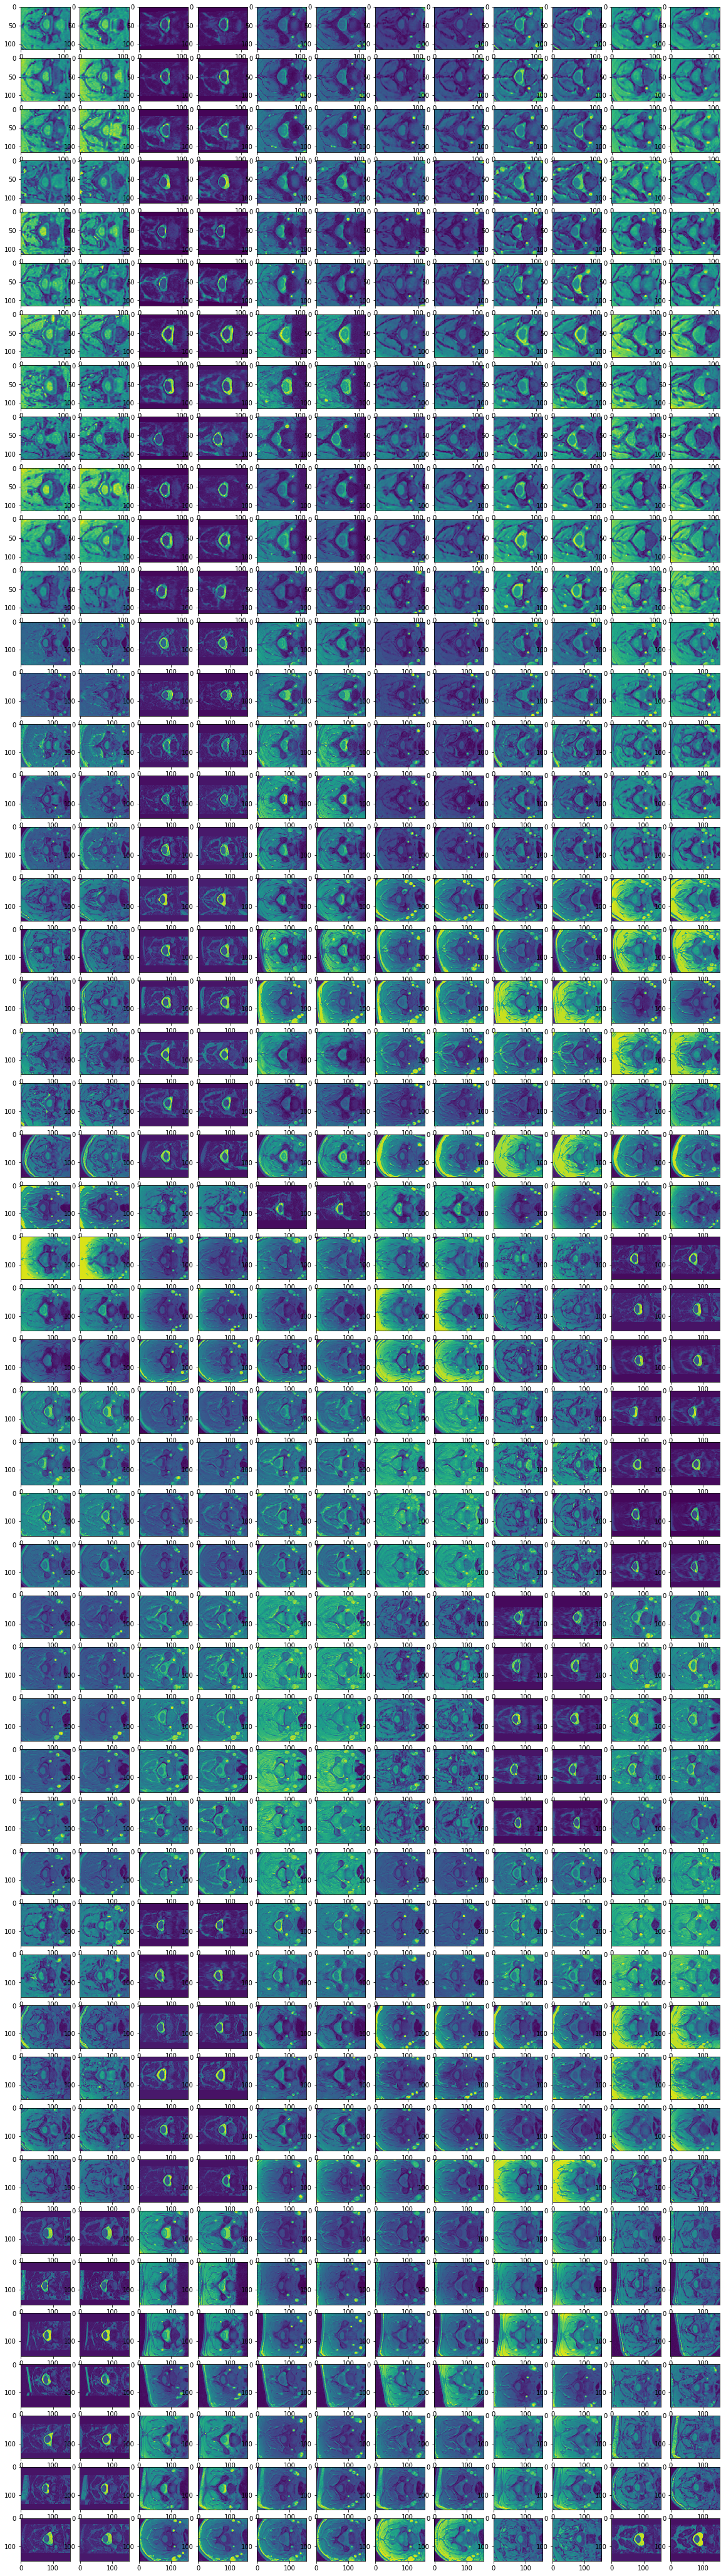

In [106]:
ncols = 12
nrows = 50
i,j = 0,0

fig, axes = plt.subplots(nrows, ncols, figsize = (20, (nrows * 3)//2))

for sl in tqdm_notebook(ds, unit = "slice"):
    axes[i,j].imshow(sl, aspect = 'auto')
    j += 1
    if j >= ncols:
        j = 0
        i += 1
    #we have to stop here because figure size is limited
    if i == nrows:
        break

#this rendering step is a bit long
fig.show()

# Feature Engineering

Here we use a pretrained VGG-16 to extract features of the images and be able to cluster it.

In [107]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [113]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns


#we encapsulate the extractor in a function
def extract_features(img):
    img_resized = resize(img, (224,224))
    img_3_channels = np.resize(img_resized, (224,224,3))
    img_vect = np.expand_dims(img_3_channels, axis = 0)
    img_in = preprocess_input(img_vect)
    features = model.predict(img_in)
    feat = features[0].flatten()
    return(feat)


features_list = []
#and then we appply it to all the slices
for sl in tqdm_notebook(ds, unit = "slice"):
    features_list.append(extract_features(sl))



# Clusterization

First a t-SNE visualization, then the actual KMeans clustering

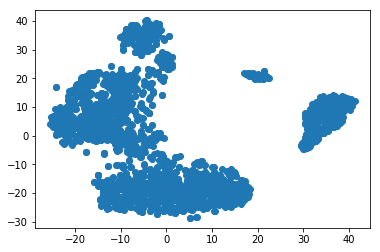

In [114]:
features_list = np.array(features_list)
pca = PCA(n_components = 50).fit(features_list).transform(features_list)
tsne_results = TSNE(n_components = 2, perplexity = 100, n_iter = 2000).fit_transform(pca)
plt.scatter(tsne_results[:,0], tsne_results[:,1])



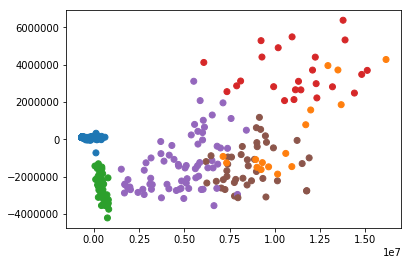

In [125]:
clusters = 6

k_means = KMeans(n_clusters=clusters, random_state=0).fit(features_list)

#generating the color palette
colors = []
palette = sns.color_palette(None, clusters)
for label in k_means.labels_:
    colors.append(palette[label])

pca_2d = PCA(n_components = 2).fit(features_list).transform(features_list)
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=colors)
plt.show()



# TODO

- [ ] Try with ResNet50 and VGG19 instead of VGG16
- [ ] Try with KMeans + MeanShift

# Random testing



In [ ]:
ex = "../duke/projects/ivado-medical-imaging/spineGeneric_201904271322/result/juntendo-750w_spineGeneric/sub-04/anat/sub-04_T1W.nii.gz"


img = nib.load(ex).get_data()

In [ ]:
sl = img[:,:,1]
np.shape(sl)


plt.imshow(sl)

In [ ]:
plt.figure()
for sl in ds:
    plt.imshow(sl)
plt.plot()

In [ ]:
slc = resize(sl, (224,224))
zeros = np.zeros((224,224))
slc = np.resize(slc, (224,224,3))
slc = np.expand_dims(slc, axis = 0)
slc = preprocess_input(slc)
features = model.predict(slc)
print(features)
feat = features[0].flatten()
print(np.shape(feat))